<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/8/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [0]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, display, load, capture metrics**

Download dataset:

In [2]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download robervalt/sunspots -p robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 32.9MB/s]


Extract .zip:

In [3]:
!unzip robervalt/sunspots/sunspots.zip -d data

Archive:  robervalt/sunspots/sunspots.zip
  inflating: data/Sunspots.csv       


Load data:

In [4]:
import pandas as pd

DATA_PATH = './data/Sunspots.csv'
VALUES = 'Monthly Mean Total Sunspot Number'

def get_dataset():
  df = pd.read_csv(DATA_PATH)
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  return df

df = get_dataset()

df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Visualize it via timeline chart:

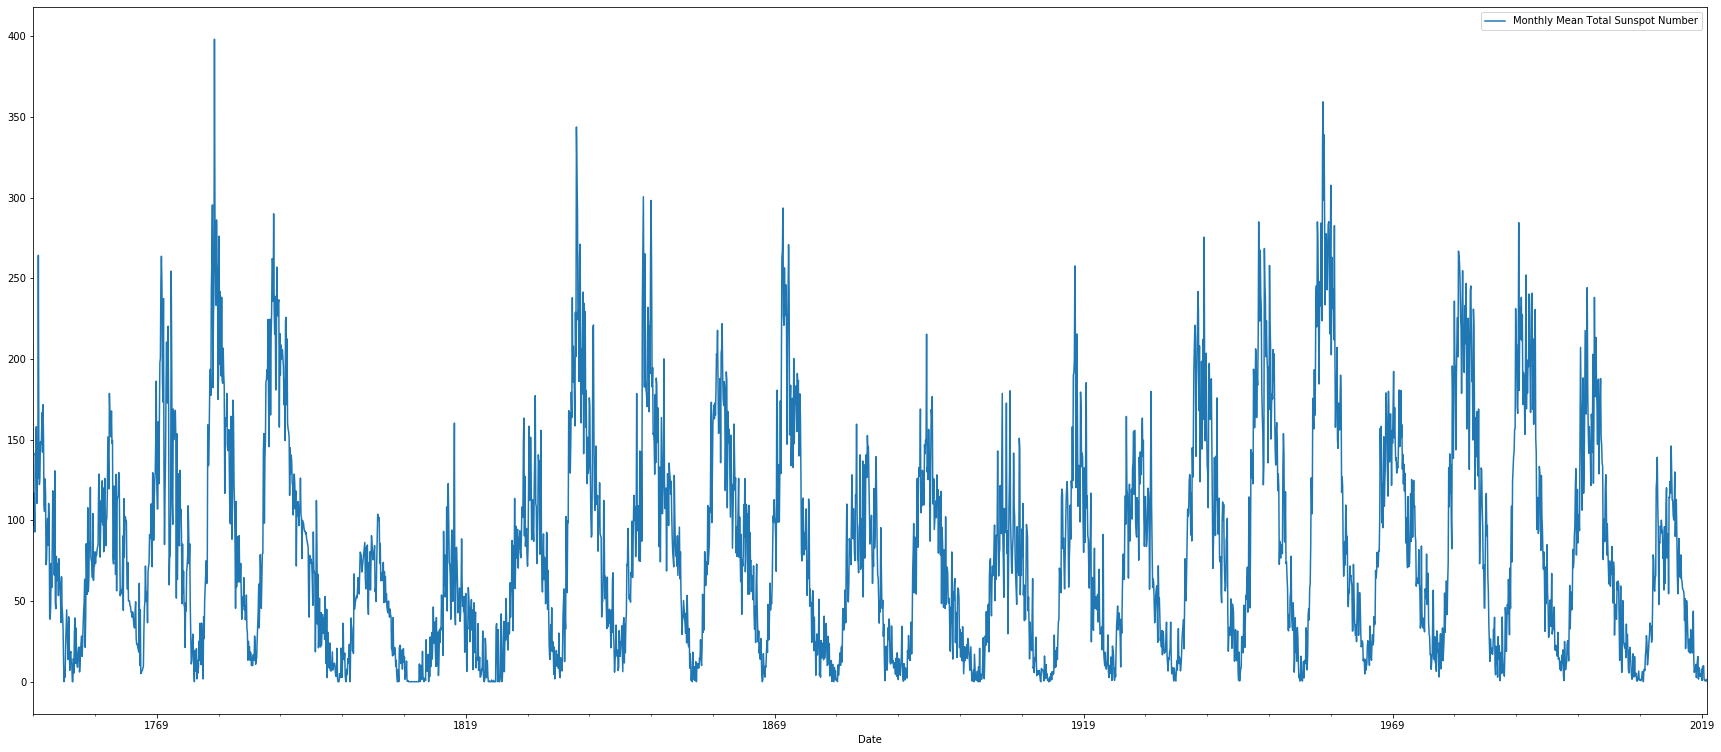

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

df_plot = get_dataset()

df_plot['Date']= pd.to_datetime(df_plot['Date'])

df_plot.plot(x = 'Date', y = VALUES)

Capture *seasonality, trend, autocorrelation*:

In [0]:
# autocorrelation
from pandas.plotting import autocorrelation_plot
plt.rcParams['figure.figsize'] = [170, 130]

series = get_dataset()
autocorrelation_plot(series[VALUES])
plt.show()

p~6

<Figure size 2160x936 with 0 Axes>

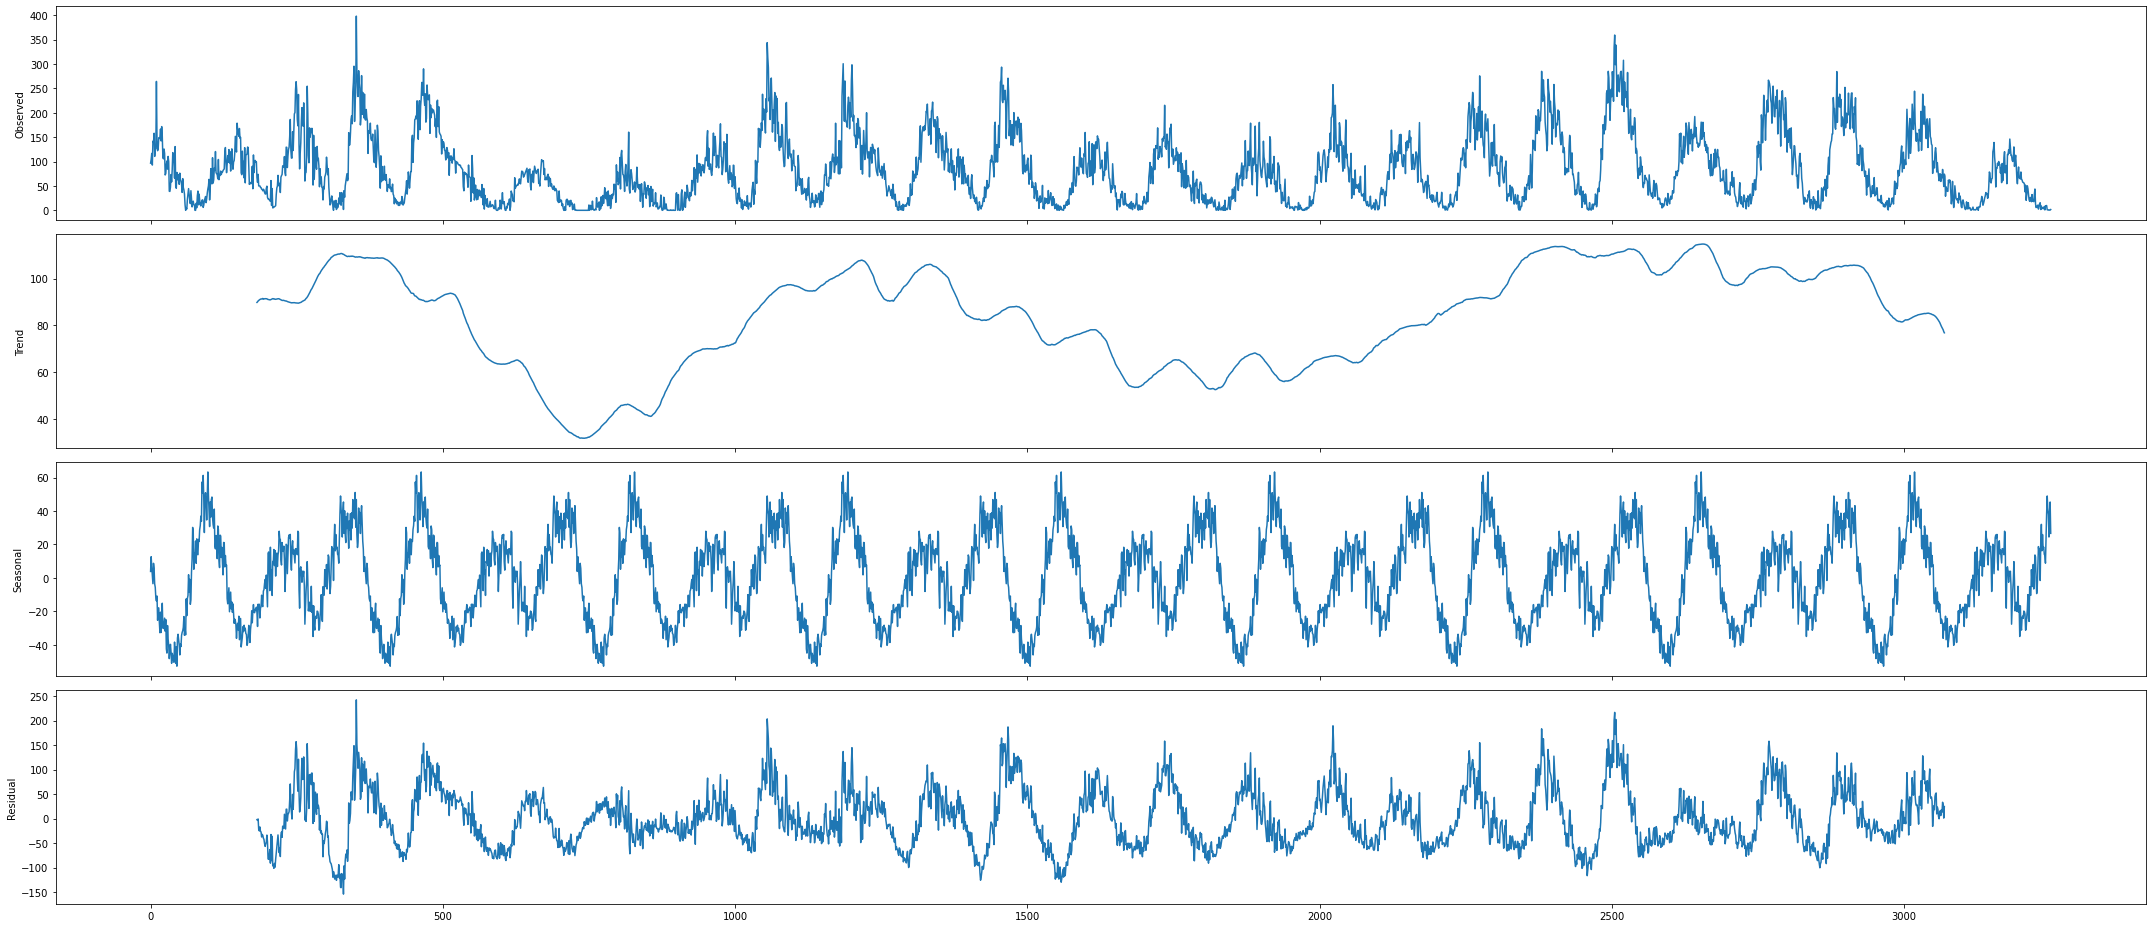

In [0]:
# trend
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

from statsmodels.tsa.seasonal import seasonal_decompose

series = get_dataset()

result = seasonal_decompose(series[VALUES], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()
fig.show()

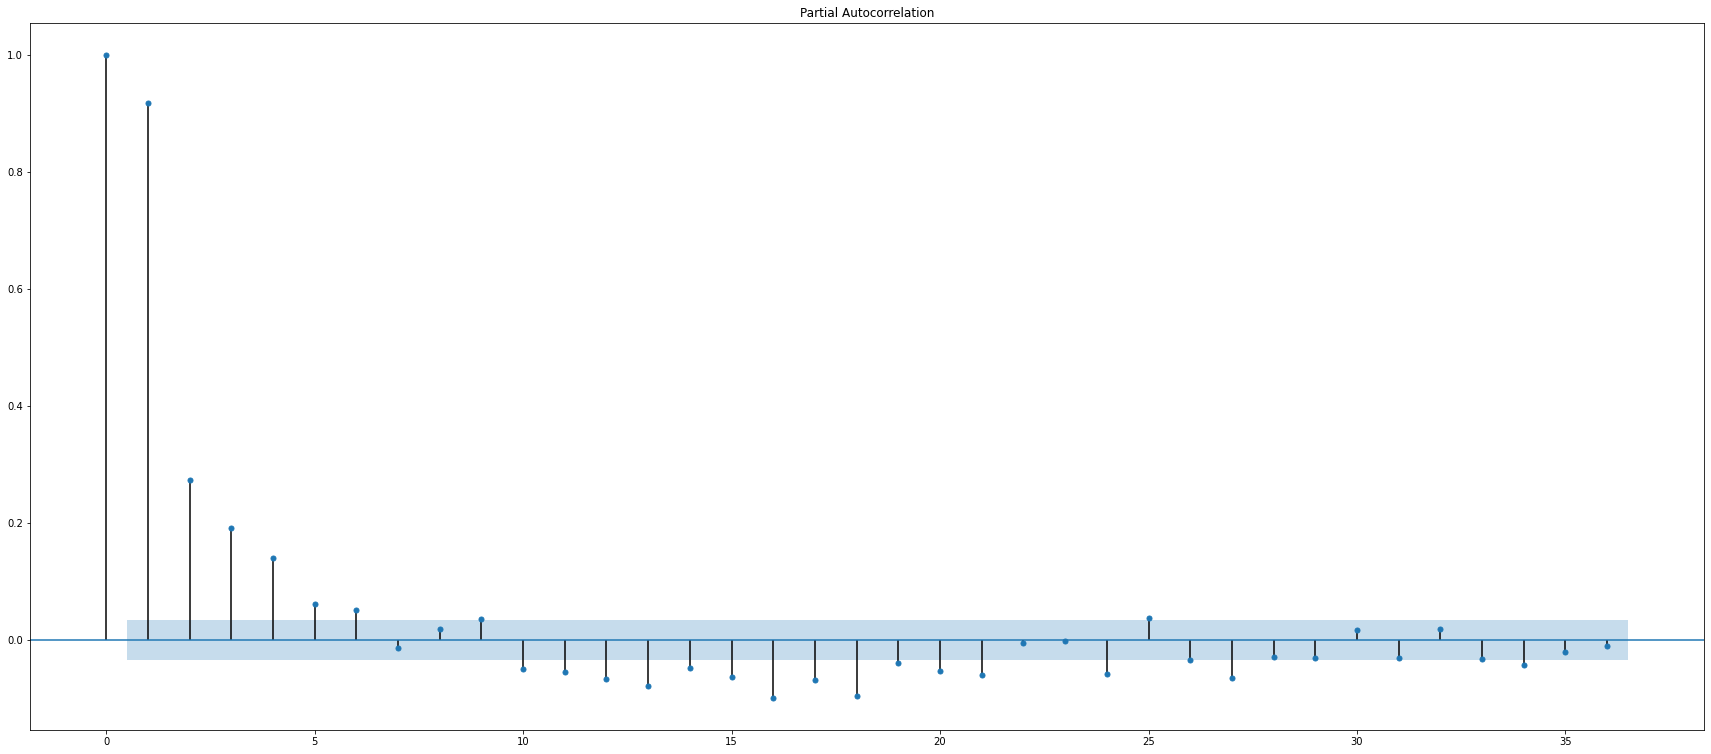

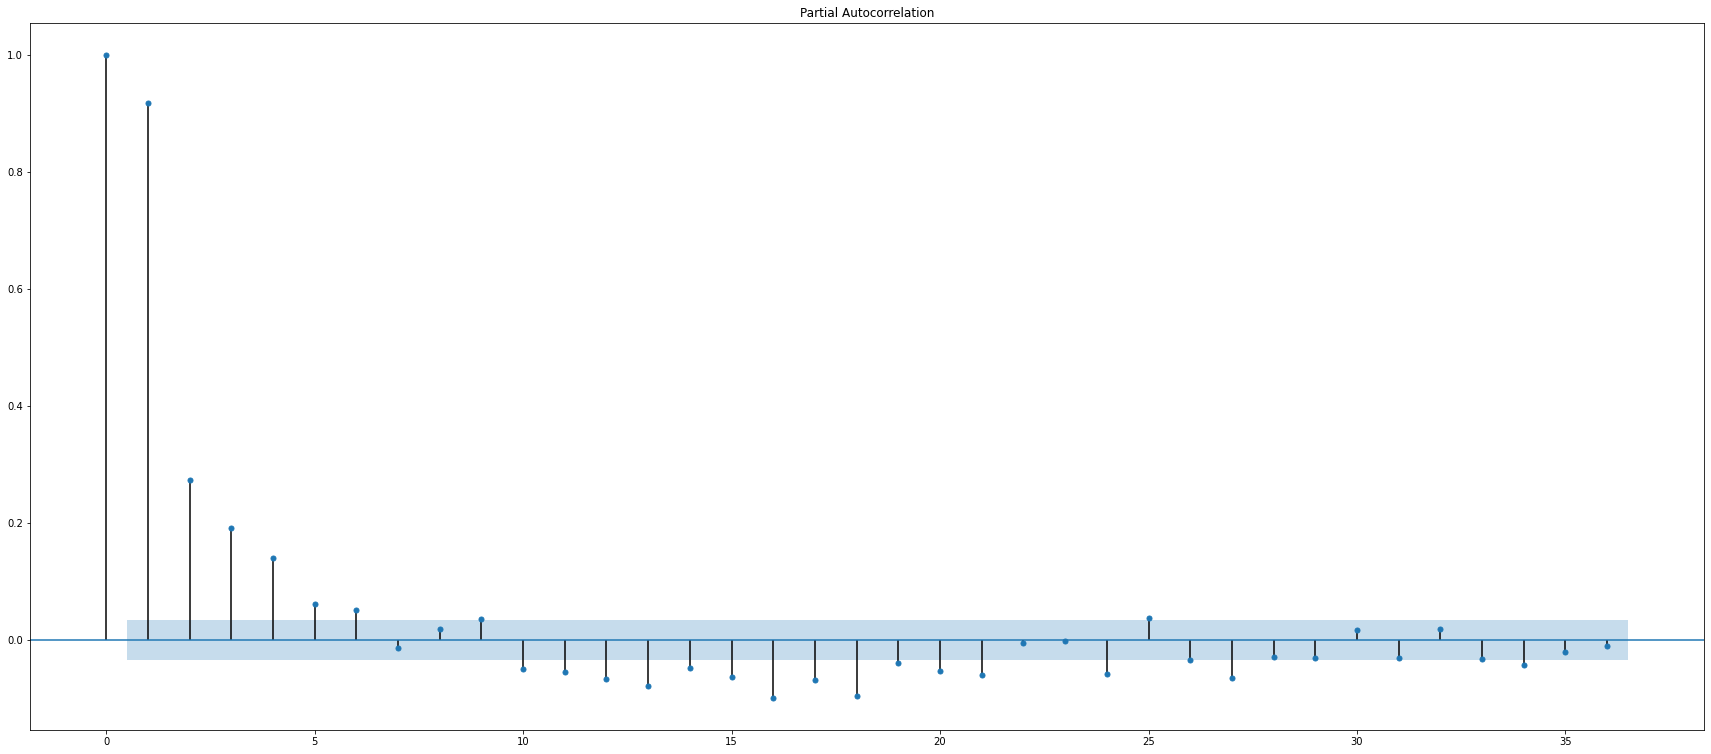

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(series[VALUES])

q~1 (blue area)

# **Part 2: dataset splitting**

Use first 70% as train-data, and other 30% as test:

In [0]:
def ts_split(data,percentage=0.7):
    n = int(data.shape[0]*percentage)
    return data[:n], data[n+1:]

train, test = ts_split(df)

# **Part 3: ARIMA as a prediction model**

In [15]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


arima = ARIMA(train[VALUES], (6,0,1), dates=train['Date']).fit()

# print summary of fit model
print(arima.summary())

# ---TODO---
# RMSE
# RAE
# Charts
history = [x for x in train[VALUES]]
tst = [x for x in test[VALUES]]

predictions = list()
for t in range(len(test[VALUES])):
	model = ARIMA(history, order=(6,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = tst[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                      ARMA Model Results                                     
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2276
Model:                                    ARMA(6, 1)   Log Likelihood              -10576.563
Method:                                      css-mle   S.D. of innovations             25.219
Date:                               Sun, 05 Apr 2020   AIC                          21171.127
Time:                                       13:37:14   BIC                          21222.699
Sample:                                   01-31-1749   HQIC                         21189.939
                                        - 08-31-1938                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=45.845027, expected=33.600000
predicted=39.120203, expected=52.000000
predicted=47.799221, expected=56.100000
predicted=50.964397, expected=77.800000
predicted=64.993761, expected=40.400000
predicted=48.463938, expected=34.200000
predicted=42.589094, expected=31.800000
predicted=40.630661, expected=48.900000
predicted=47.825525, expected=37.900000
predicted=42.981495, expected=5.900000
predicted=22.385020, expected=14.700000
predicted=23.190951, expected=39.600000
predicted=35.476534, expected=18.300000
predicted=24.714338, expected=31.500000
predicted=30.551423, expected=12.700000
predicted=20.728942, expected=33.600000
predicted=30.270629, expected=28.000000
predicted=29.894487, expected=12.300000
predicted=20.000007, expected=2.500000
predicted=13.596122, expected=3.900000
predicted=11.551183, expected=0.400000
predicted=8.259690, expected=0.800000
predicted=6.657546, expected=15.800000
predicted=13.905943, expected=2.700000
predicted=7.389457, expected=1.200000
predicted=

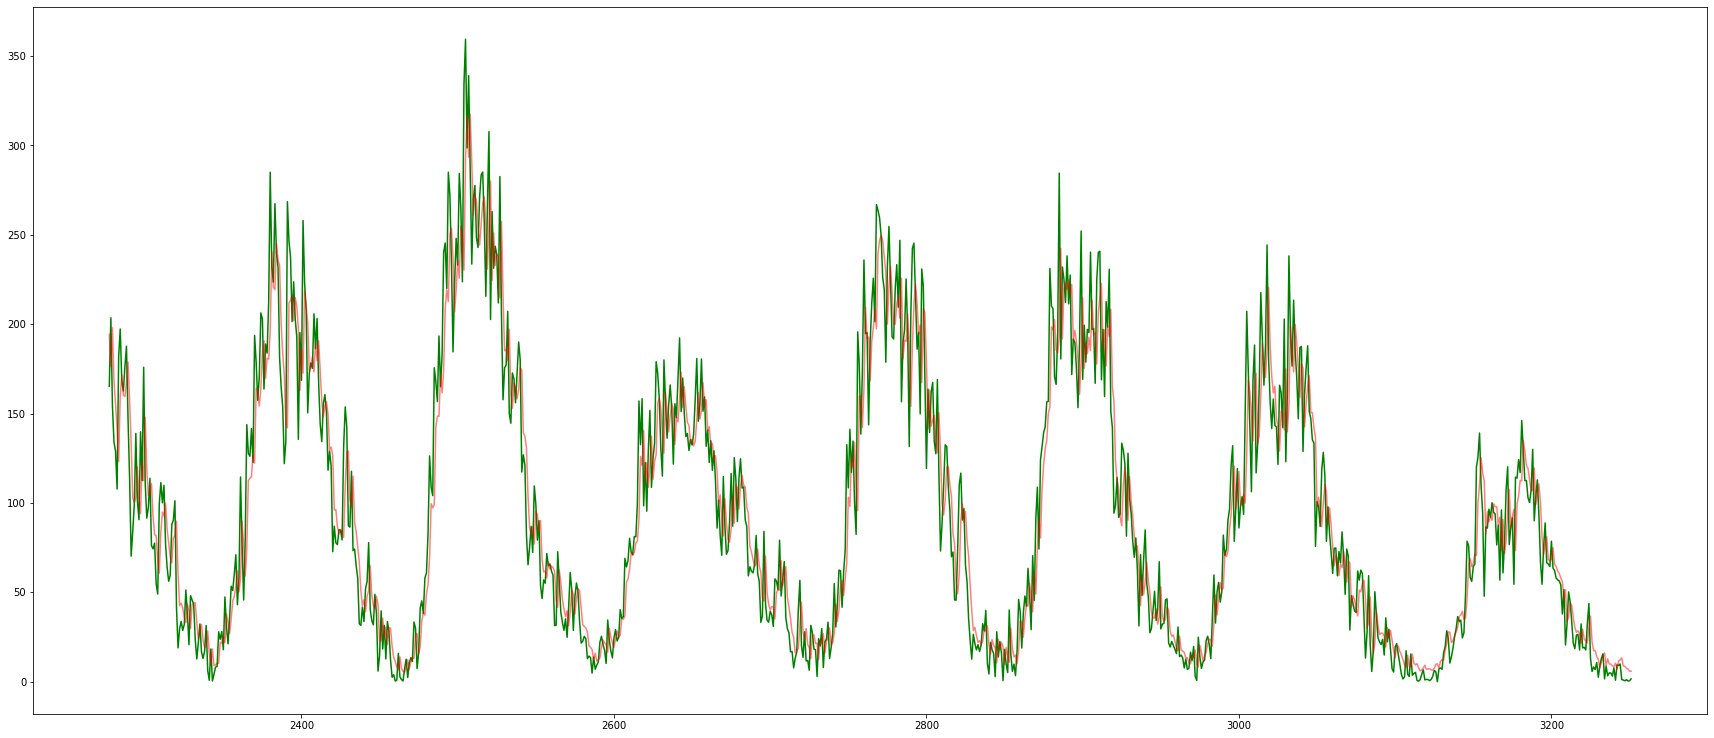

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

def predictions_to_test(predictions):
    train, test = ts_split(get_dataset())
    test[VALUES] = predictions

    return test

prd = predictions_to_test(predictions)

plt.plot(test[VALUES], color='green')
plt.plot(prd[VALUES], color='red', alpha=0.5)

plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(tst, predictions))

610.7637117594122


# **Part 4: RNN as a prediction model**

Convert time-series to sequence->value format

In [0]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

NN model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

n_features = 1
# choose a number of time steps
n_steps = 14

model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.save_weights('model.h5')

Data preprocessing

In [0]:
ds = get_dataset()
train, test = ts_split(ds)

# split into samples
X, y = split_sequence(train[VALUES], n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

Train

In [23]:
# reset weights
model.load_weights('model.h5')
# fit model
model.fit(X, y, epochs=30, verbose=1)
# demonstrate prediction
x_input = X[0]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y[0])

Epoch 1/30
71/71 [==============================] - 1s 13ms/step - loss: 1759.9371
Epoch 2/30
71/71 [==============================] - 1s 13ms/step - loss: 854.8083
Epoch 3/30
71/71 [==============================] - 1s 13ms/step - loss: 726.1531
Epoch 4/30
71/71 [==============================] - 1s 13ms/step - loss: 702.6740
Epoch 5/30
71/71 [==============================] - 1s 13ms/step - loss: 711.6647
Epoch 6/30
71/71 [==============================] - 1s 13ms/step - loss: 704.3303
Epoch 7/30
71/71 [==============================] - 1s 13ms/step - loss: 765.5162
Epoch 8/30
71/71 [==============================] - 1s 13ms/step - loss: 754.8272
Epoch 9/30
71/71 [==============================] - 1s 13ms/step - loss: 738.0470
Epoch 10/30
71/71 [==============================] - 1s 13ms/step - loss: 701.5232
Epoch 11/30
71/71 [==============================] - 1s 13ms/step - loss: 1103.8971
Epoch 12/30
71/71 [==============================] - 1s 13ms/step - loss: 1028.0380
Epoch 13/3

Prediction

In [0]:
import numpy as np

def predict(last_n_steps, replaceable):
    dfc = pd.DataFrame([], columns=('Date', VALUES))
    last_values = last_n_steps.to_numpy()
    n = replaceable.first_valid_index()
    for index, row in replaceable.iterrows():
        cp = row[VALUES]
        row[VALUES] = model.predict(last_values.reshape((1, n_steps, n_features)), verbose=0)[0][0]
        last_values = np.append(last_values, [cp])[-n_steps:]
        dfc = dfc.append(row)
    
    return dfc

predictions_nn = predict(train[VALUES][:n_steps], test)

Draw a chart:

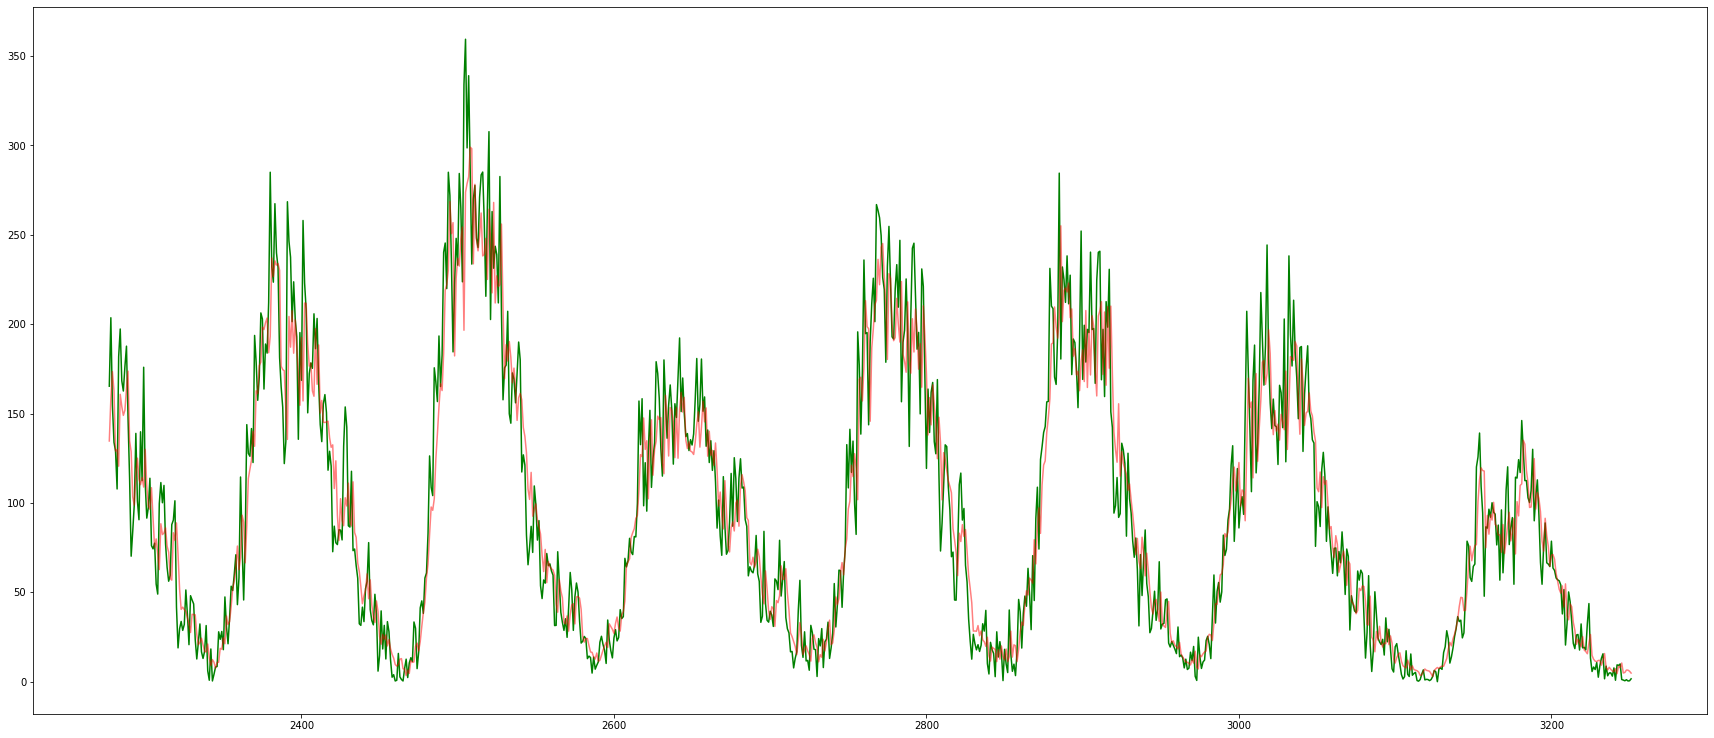

In [26]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 13]

train, test = ts_split(ds)

plt.plot(test[VALUES], color='green')
plt.plot(predictions_nn[VALUES], color='red', alpha=0.5)

plt.show()

In [27]:
print(mean_squared_error(tst, predictions_nn[VALUES]))

611.7068908120754


# **Part 5: final notes**

MSE ~ equal to each other